In [1]:
import numpy as np
import numpyro
import numpyro.distributions as dist
from jax import random
from numpyro.infer import MCMC, HMC,NUTS
import fitsio
import matplotlib as mpl
from multiprocessing import Pool
from scipy.stats import dirichlet
from astropy.table import Table
from astropy.io import fits
import fitsio
from astropy.cosmology import Planck18
import jax.numpy as jnp
import matplotlib.pyplot as plt
from numpyro import handlers 
from jax import random, jit
import jax
from fitting import abs_mag_to_L,get_lfpars_shen20,T0,T1,T2,get_lfpars,get_phis
from jax import random, vmap
from jax.scipy.stats import norm
import numpyro.distributions as dist

In [2]:
# Verify the installation
print("JAX version:", jax.__version__)
print("JAX is using CUDA:", jax.lib.xla_bridge.get_backend().platform)

# Enable 64-bit floating point precision
jax.config.update("jax_enable_x64", True)

# Verify the update
print("jax_enable_x64:", jax.config.read("jax_enable_x64"))

JAX version: 0.4.30
JAX is using CUDA: gpu
jax_enable_x64: True


In [3]:
# Check available devices
print("Available devices:", jax.devices())

# Simple CPU computation test
x = jnp.array([1.0, 2.0, 3.0])
y = jax.device_put(x, jax.devices('gpu')[0])
z = y ** 2
print("Computation result:", z)

Available devices: [cuda(id=0)]


2024-06-20 14:42:49.663853: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.0 which is older than the ptxas CUDA version (12.4.131). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


Computation result: [1. 4. 9.]


In [4]:
k = Table.read('/pscratch/sd/z/zhaozhon/DATASET/DESI-data/k.csv',format='csv')
indice = np.isnan(k['k_gg']) | np.isinf(k['k_gg']) | np.isnan(k['k_rr']) | np.isinf(k['k_rr'])
k_gg = k['k_gg'][~indice]
k_rr = k['k_rr'][~indice]

In [5]:
file = '/pscratch/sd/z/zhaozhon/DATASET/DESI-data/new_d.fits'
d = Table(fitsio.read(file))
SEL = np.where((d['Z'] > 2.3) & (d['Z'] < 2.8))[0]
apr_mag_g = d['APP_MAG_G'][SEL][~indice]
apr_mag_g_err = d['APP_MAGERR_G'][SEL][~indice]
apr_mag_r = d['APP_MAG_R'][SEL][~indice]
apr_mag_r_err = d['APP_MAGERR_R'][SEL][~indice]
z = d['Z'][SEL][~indice]

In [6]:
d = Planck18.distmod(z).value

In [7]:
apr_mag_g = apr_mag_g.astype(np.float64)
apr_mag_g_err = apr_mag_g_err.astype(np.float64)
k_gg = k_gg.astype(np.float64)

apr_mag_r = apr_mag_r.astype(np.float64)
apr_mag_r_err = apr_mag_r_err.astype(np.float64)
k_rr = k_rr.astype(np.float64)

d = d.astype(np.float64)
z = z.astype(np.float64)

In [8]:
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from jax import vmap, random
from jax.scipy.stats import norm
from numpyro.infer import MCMC, NUTS
from jax import jit

'''
# Efficiency function with epsilon to avoid division by zero
def efficiency(x, m0):
    return jnp.where(x < m0, 1, m0 / x)

def integrand(y, a, k, d, magerr):
    return jnp.exp(-0.5 * ((y - (a + k + d)) / magerr) ** 2) / y
# Normalization coefficient
def normalization_coefficient(k, d, magerr, z, x, m0):
    a_values = jnp.linspace(-40, 0, k.shape[0])  # Wide range for a
    y_greater = jnp.linspace(m0, 100, k.shape[0])  # Adjust the range and number of points as needed

    def integral_less(a):
        erf_term = 0.5 * (1 + jax.scipy.special.erf((m0 - (a + k + d)) / (jnp.sqrt(2) * magerr)))
        L = abs_mag_to_L(a + x)
        lum_func = get_phis(L, z, "shen20")
        return (1 / jnp.sqrt(2 * jnp.pi * magerr ** 2)) * lum_func * erf_term

    def integral_greater(a):
        L = abs_mag_to_L(a + x)
        lum_func = get_phis(L, z, "shen20")
        integral_y = jnp.trapezoid(integrand(y_greater, a, k, d, magerr), y_greater)
        return (1 / jnp.sqrt(2 * jnp.pi * magerr ** 2)) * lum_func * integral_y

    integral_less_vals = jnp.array([integral_less(a) for a in a_values])
    integral_greater_vals = jnp.array([integral_greater(a) for a in a_values])

    integral_less_total = jnp.trapezoid(integral_less_vals, a_values)
    integral_greater_total = jnp.trapezoid(integral_greater_vals, a_values)

    integral = integral_less_total + integral_greater_total
    #print(integral)
    return 1 / integral

# Combined probability density function
def combined_log_probability_density(k, d, x, mag_apr, magerr, z, m0):
    a_values = jnp.linspace(-40, 0, k.shape[0])
    def log_prob_density(M_T):
        log_normal_dist = norm.logpdf(mag_apr, loc=M_T + k + d, scale=magerr)
        L = abs_mag_to_L(M_T + x)
        log_lum_func = jnp.log(get_phis(L, z, "shen20"))
        log_eff_func = jnp.log(efficiency(mag_apr, m0))
        return log_normal_dist + log_lum_func + log_eff_func
    
    log_probs = jnp.array([log_prob_density(M_T) for M_T in a_values])
    integral_log_prob = jnp.trapezoid(log_probs, a_values)
    
    log_norm_coeff = jnp.log(normalization_coefficient(k, d, magerr, z, x, m0))
    return integral_log_prob + log_norm_coeff

# Model function
def model(k, d, mag_apr, magerr, z):
    # Priors for the parameters
    x = numpyro.sample('x', dist.Uniform(-10, 1000))
    m0 = numpyro.sample('m0', dist.Uniform(0.1, 30))  # Adjusted prior range

    # Sample M_T for each data point

    # Compute the log-likelihood for each data point
    log_likelihoods = combined_log_probability_density(k, d, x, mag_apr, magerr, z, m0)

    # Sum of log-likelihoods
    total_log_likelihood = jnp.sum(log_likelihoods)

    # Observation likelihood
    numpyro.factor('obs', total_log_likelihood)
'''

# Efficiency function with epsilon to avoid division by zero
@jit
def efficiency(x, m0):
    return jnp.where(x < m0, 1, m0 / x)

# Normalization coefficient
@jit
def normalization_coefficient(k, d, magerr, M_T, z, x, m0):
    L = abs_mag_to_L(M_T + x)
    lum_func = get_phis(L, z, "shen20")
    
    # Simplified integral when y < m0
    erf_term = 0.5 * (1 + jax.scipy.special.erf((m0 - (M_T + k + d)) / (jnp.sqrt(2) * magerr)))
    integral_less = (1 / jnp.sqrt(2 * jnp.pi * magerr**2)) * lum_func * erf_term
    
    # Simplified integral when y > m0
    def integrand(y):
        return jnp.exp(-0.5 * ((y - (M_T + k + d)) / magerr)**2) / y
    
    y_greater = jnp.linspace(m0, 100, k.shape[0])  # Adjust the range and number of points as needed
    integral_greater = (1 / jnp.sqrt(2 * jnp.pi * magerr**2)) * lum_func * jnp.trapezoid(integrand(y_greater), y_greater)
    
    # Combine the two parts
    integral = integral_less + integral_greater
    return 1 / integral

# Combined probability density function
@jit
def combined_log_probability_density(M_T, k, d, x, mag_apr, magerr, z, m0):
    log_normal_dist = norm.logpdf(mag_apr, loc=M_T + k + d, scale=magerr)
    L = abs_mag_to_L(M_T + x)
    log_lum_func = jnp.log(get_phis(L, z, "shen20"))
    log_eff_func = jnp.log(efficiency(mag_apr, m0))
    log_norm_coeff = jnp.log(normalization_coefficient(k, d, magerr, M_T, z, x, m0))
    return log_normal_dist + log_lum_func + log_eff_func + log_norm_coeff

# Model function
def model(k, d, mag_apr, magerr, z):
    # Priors for the parameters
    x = numpyro.sample('x', dist.Uniform(-10, 10))
    m0 = numpyro.sample('m0', dist.Uniform(0.1, 30))  # Adjusted prior range

    # Sample M_T for each data point
    M_T = numpyro.sample('M_T', dist.Uniform(-40, 0).expand([len(k)]))  # Adjust the range as needed

    # Compute the log-likelihood for each data point
    log_likelihoods = combined_log_probability_density(M_T, k, d, x, mag_apr, magerr, z, m0)

    # Sum of log-likelihoods
    total_log_likelihood = jnp.sum(log_likelihoods)

    # Observation likelihood
    numpyro.factor('obs', total_log_likelihood)

In [9]:
# Initialize RNG
rng_key = random.PRNGKey(0)

# Sampler configuration
num_warmup, num_samples = 3000, 7000
i_start = 0
i_end = i_start+3000
# Initialize batch parameters for the entire dataset

init_params = {
    'x': -2 * jnp.ones((1,)),  
    'm0': 15 * jnp.ones((1,)),  
}

# Set up the NUTS sampler
kernel = NUTS(model, target_accept_prob=0.8)
#kernel = HMC(model)
mcmc = MCMC(kernel, num_warmup=num_warmup, num_samples=num_samples, num_chains=1, jit_model_args=True, progress_bar=True)

# Run the sampler over the entire dataset
#mcmc.run(rng_key, apr_mag_g, apr_mag_g_err, k_gg, apr_mag_r, apr_mag_r_err, k_rr, d,z, 22.5, init_params=init_params)
mcmc.run(rng_key, k_rr[i_start:i_end], d[i_start:i_end], apr_mag_r[i_start:i_end], apr_mag_r_err[i_start:i_end], z[i_start:i_end])

# Get samples
samples = mcmc.get_samples()

# Optionally, process or save your samples
print(samples)

sample: 100%|██████████| 10000/10000 [1:21:14<00:00,  2.05it/s, 1023 steps of size 8.71e-07. acc. prob=0.84]


{'M_T': Array([[-26.45879739, -12.17840598, -21.02665539, ..., -18.05972425,
        -26.95972365, -28.16068872],
       [-26.45879863, -12.1784045 , -21.02665913, ..., -18.05972225,
        -26.95972252, -28.16069001],
       [-26.4587794 , -12.17841105, -21.02666877, ..., -18.05972466,
        -26.95972775, -28.1606942 ],
       ...,
       [-26.45906452, -12.183351  , -21.02883352, ..., -18.06798955,
        -26.96036757, -28.15814947],
       [-26.45905889, -12.18333994, -21.02881937, ..., -18.06799382,
        -26.9603603 , -28.15815592],
       [-26.45905665, -12.18333924, -21.02881639, ..., -18.06799704,
        -26.96035763, -28.1581558 ]], dtype=float64), 'm0': Array([12.28479449, 12.28479418, 12.28479811, ..., 12.28457748,
       12.28458173, 12.28458623], dtype=float64), 'x': Array([6.01784912, 6.01785076, 6.01785717, ..., 6.01775195, 6.01775144,
       6.01775247], dtype=float64)}


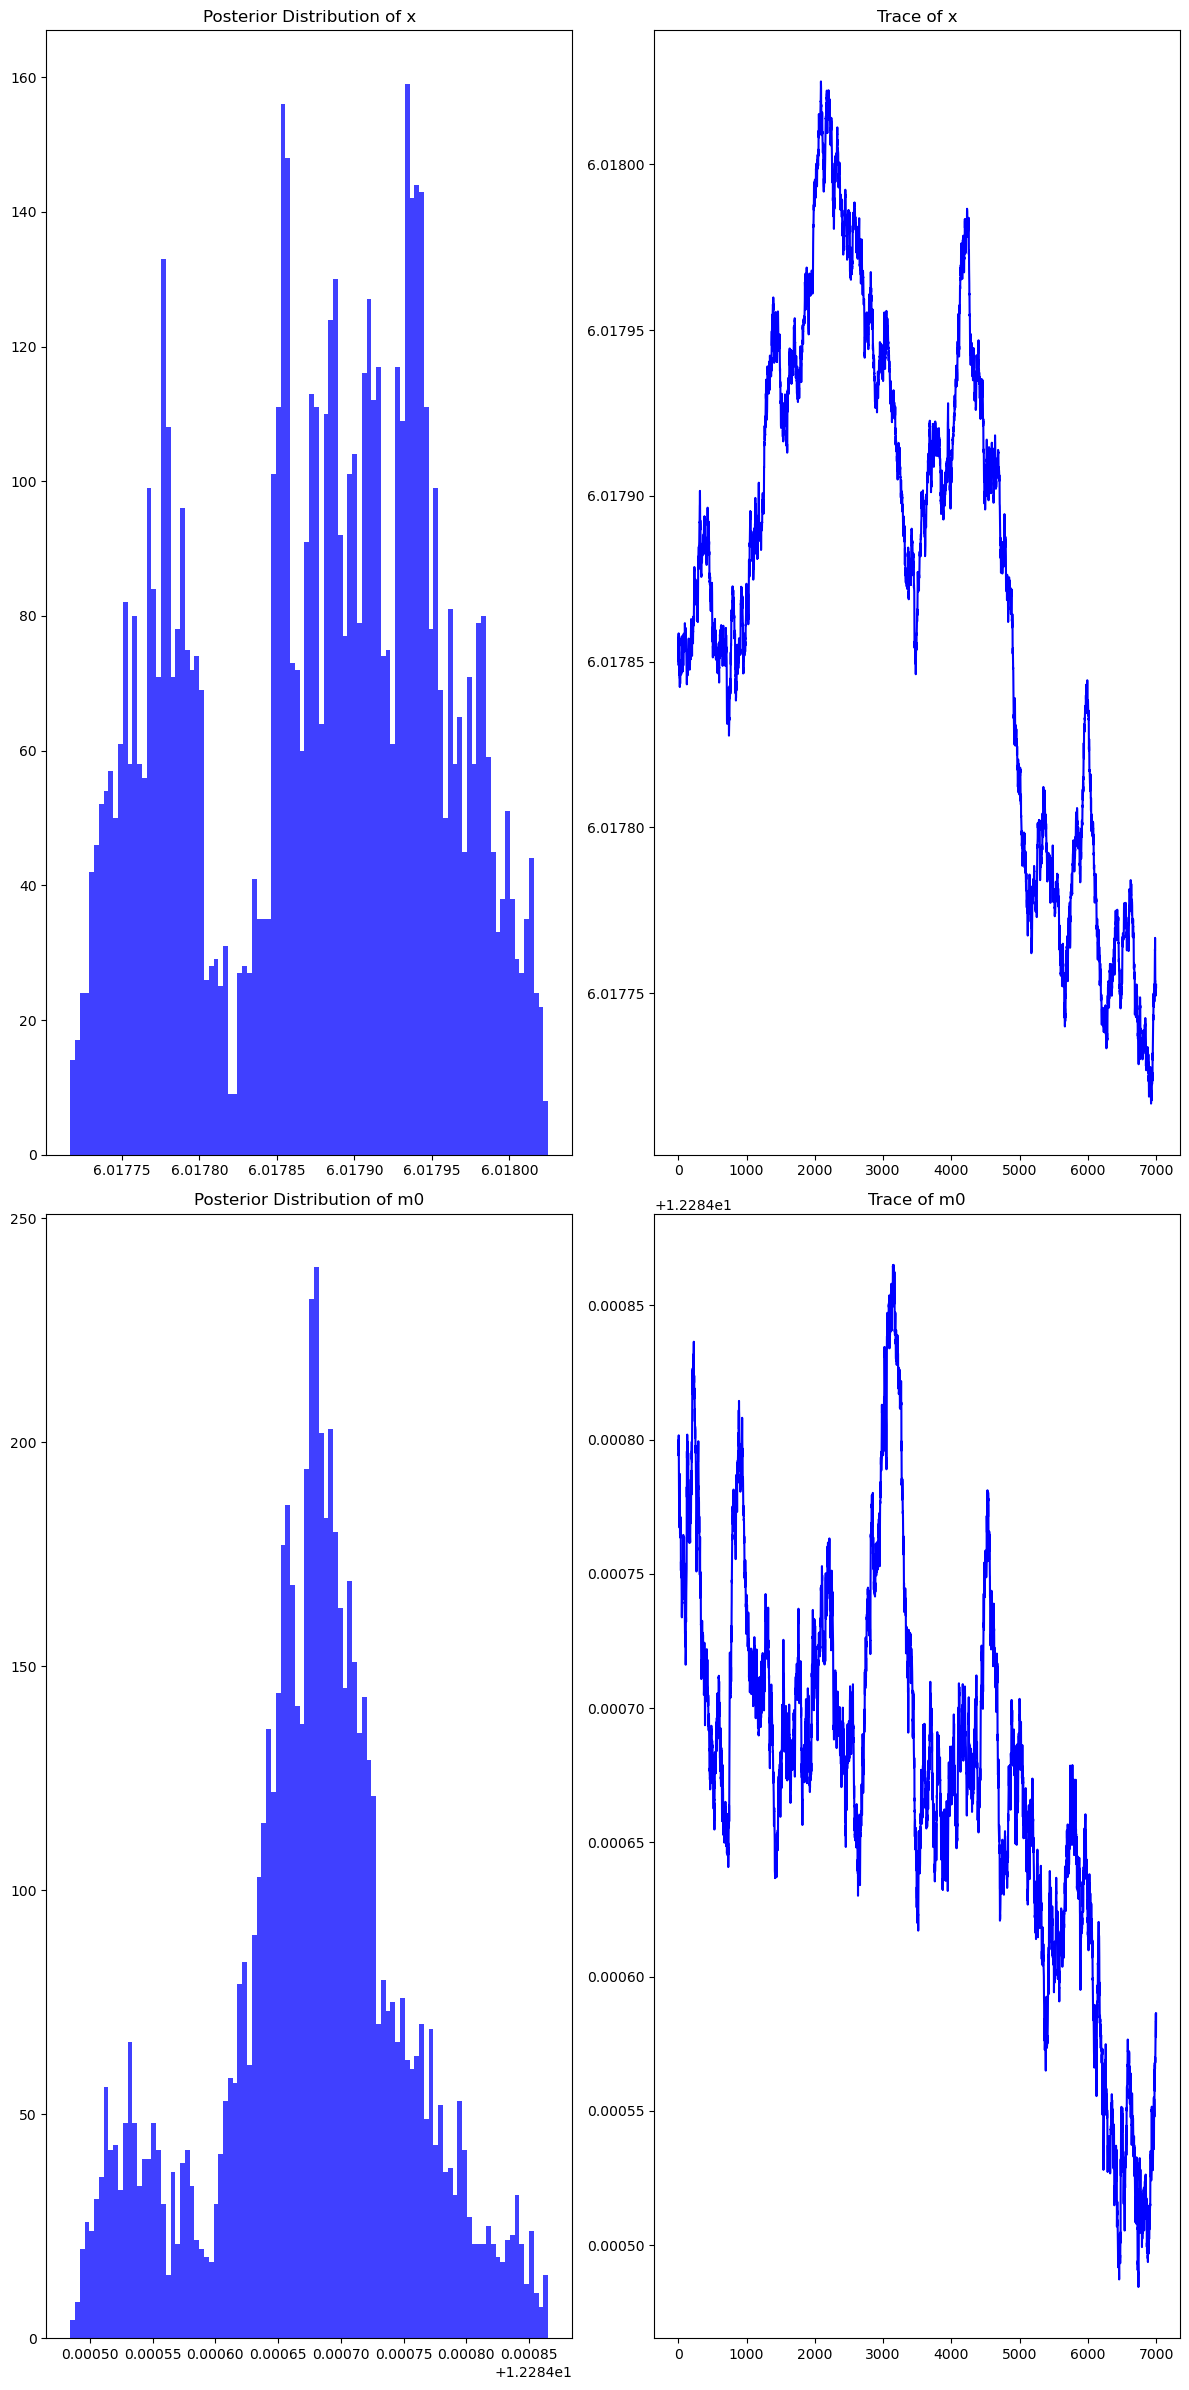

In [10]:
# Extract the chains and parameters
x = samples['x']
m0 = samples['m0']
# Creating a figure to hold the subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 24))  # 7 parameters, each with a histogram and trace plot

# Helper function to plot histograms and traces
def plot_param(ax, data, title):
    ax[0].hist(data, bins=100, alpha=0.75, color='blue')
    ax[0].set_title(f'Posterior Distribution of {title}')
    ax[1].plot(data, color='blue')
    ax[1].set_title(f'Trace of {title}')

# Plotting each parameter
plot_param(axs[0], x, 'x')
plot_param(axs[1], m0, 'm0')
# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

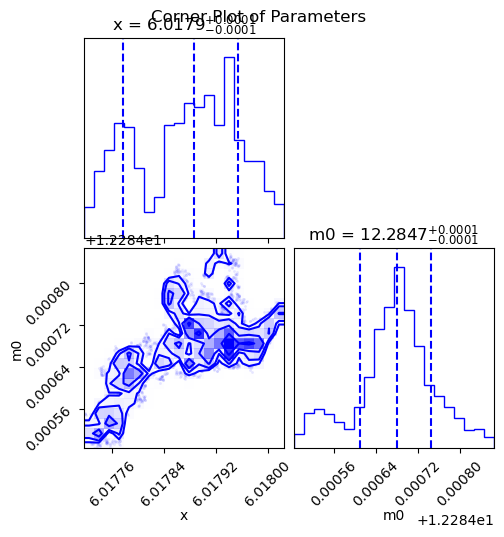

In [11]:
import corner
# Extract samples for plotting
samples = np.vstack((x, m0)).T

# Create a corner plot
fig = corner.corner(samples, labels=['x', 'm0'], 
                    show_titles=True,quantiles=[0.16, 0.5, 0.84],
                       plot_contours=True, color='blue', title_kwargs={"fontsize": 12},title_fmt=".4f")

fig.suptitle('Corner Plot of Parameters')
fig.show()